# KNN Algorithm - Experiments

## External lib Imports

In [61]:
import itertools

import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set()

## Loading the dataset

In [2]:
df = pd.read_csv('normalized_dataset.csv')
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   structureId               1046 non-null   object 
 1   classification            1046 non-null   object 
 2   experimentalTechnique     1046 non-null   object 
 3   macromoleculeType         1046 non-null   object 
 4   residueCount              1046 non-null   float64
 5   resolution                1046 non-null   float64
 6   structureMolecularWeight  1046 non-null   float64
 7   crystallizationMethod     1046 non-null   object 
 8   crystallizationTempK      1046 non-null   float64
 9   densityMatthews           1046 non-null   float64
 10  densityPercentSol         1046 non-null   float64
 11  pdbxDetails               1046 non-null   object 
 12  phValue                   1046 non-null   float64
 13  publicationYear           1046 non-null   float64
dtypes: float

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
residueCount,1046.0,0.161252,0.176538,0.0,0.061674,0.079295,0.185022,1.0
resolution,1046.0,0.471832,0.199016,0.0,0.324167,0.453333,0.633333,1.0
structureMolecularWeight,1046.0,0.167043,0.181501,0.0,0.058923,0.082904,0.203352,1.0
crystallizationTempK,1046.0,0.458200,0.204906,0.0,0.400000,0.500000,0.550000,1.0
densityMatthews,1046.0,0.338491,0.196870,0.0,0.216495,0.278351,0.419244,1.0
densityPercentSol,1046.0,0.489044,0.161379,0.0,0.388723,0.465054,0.590074,1.0
phValue,1046.0,0.463270,0.181922,0.0,0.277778,0.551389,0.555556,1.0
publicationYear,1046.0,2006.444551,7.291752,1985.0,2001.000000,2007.000000,2012.000000,2017.0


In [4]:
features = [
    'residueCount',
    'resolution',
    'structureMolecularWeight',
    'crystallizationTempK',
    'densityMatthews',
    'densityPercentSol',
    'phValue'
]

In [5]:
df.head(5)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,102D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.533333,0.079033,"VAPOR DIFFUSION, SITTING DROP",0.1,0.271478,0.449662,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",0.555556,1995.0
1,110D,DNA,X-RAY DIFFRACTION,DNA,0.000000,0.433333,0.007167,"VAPOR DIFFUSION, SITTING DROP",0.1,0.484536,0.631381,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",0.444444,1993.0
2,111D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.550000,0.075475,"VAPOR DIFFUSION, SITTING DROP",0.1,0.274914,0.452646,"pH 6.60, VAPOR DIFFUSION, SITTING DROP, temper...",0.444444,1989.0
3,113D,DNA,X-RAY DIFFRACTION,DNA,0.079295,0.633333,0.075231,"VAPOR DIFFUSION, SITTING DROP",0.2,0.295533,0.473692,"pH 7.40, VAPOR DIFFUSION, SITTING DROP, temper...",0.666667,1987.0
4,117D,DNA,X-RAY DIFFRACTION,DNA,0.026432,0.650000,0.025144,VAPOR DIFFUSION,0.1,0.522337,0.654311,"pH 6.50, VAPOR DIFFUSION, temperature 277.00K",0.416667,1992.0


## Distance Functions

> We employ the following distance funcions
>
>>Manhattan
>>
>>Euclidean
>>
>>Minkowski

## Voting functions

> Standard
>
> Harmonic
>
> Inverse of distance

In [6]:
def harmonic(distances: np.array) -> np.array:
    """
    Calculate harmonic weights using a distance array 
    """
    
    weights = np.zeros(distances.shape)
    
    for i, pos in enumerate(distances.argsort()):
        weights[0][pos] = 1 / (i + 1)
    
    return weights

### Experiments configs

In [7]:
"""
Each model presents a "p" parameter that set the
distance metric employed based on the minkowski formula.

1 -> manhattan;
2 -> euclidean;
p > 2: minkowski for p; 

"""

# Preliminar Test KNN configs
#
NUM_NEIGHBORS = 5
p = 2


standard_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'p': p
}

harmonic_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'weights': harmonic,
    'p': p
}

distance_params = {
    'n_neighbors': NUM_NEIGHBORS,
    'weights': 'distance',
    'p': p
}

### Classification function

In [8]:
def classification(
    features: pd.DataFrame,
    target: np.array,
    knn_params: dict,
    n_splits: int) -> tuple:
    """docstring"""
    
    model = KNeighborsClassifier(**knn_params)
    kf = KFold(n_splits=n_splits)

    results = []
    valids = []

    for train_idx, test_idx in kf.split(features):

        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]

        model.fit(X_train, y_train)
                
        predicts = [
            model.predict(np.array([list(row)]))[0]
            for _, row in X_test.iterrows()
        ]
        
        results.append(predicts)
        valids.append(y_test)

    return results, valids

In [9]:
def classification_benchmark(
    features: pd.DataFrame,
    target: np.array,
    knn_params: dict,
    n_splits: int) -> list:
    """docstring"""
    
    model = KNeighborsClassifier(**knn_params)
    kf = KFold(n_splits=n_splits)

    accuracy = []

    for train_idx, test_idx in kf.split(features):

        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]

        model.fit(X_train, y_train)
        
        accuracy.append(
            accuracy_score(y_test, model.predict(X_test), normalize=True)*100)
        
    return accuracy

## Testing KNN variations

### KNN with harmonic weights

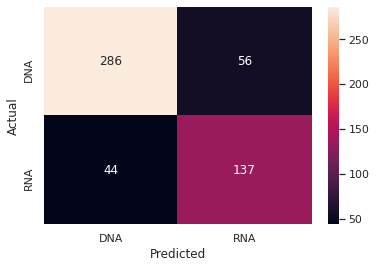

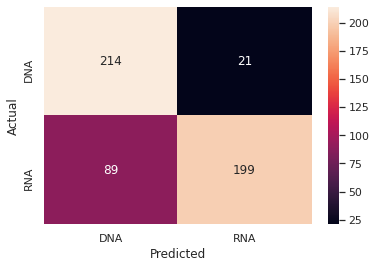

In [10]:
predictions, valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    harmonic_params,
    n_splits=2
)

for pred, valid in zip(predictions, valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()


### Standard KNN

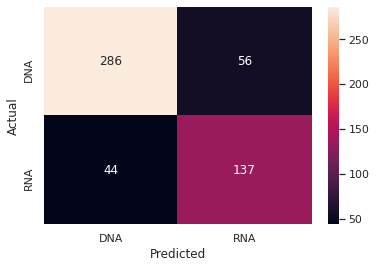

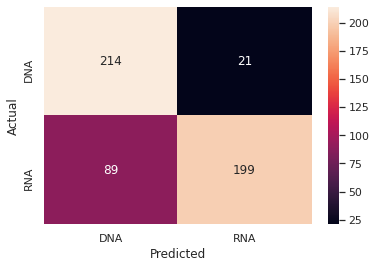

In [11]:
std_preds, std_valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    standard_params,
    n_splits=2
)

for pred, valid in zip(std_preds, std_valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()

### Inverse Distance Weight KNN

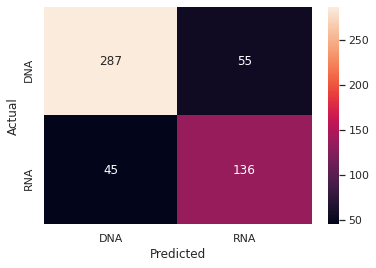

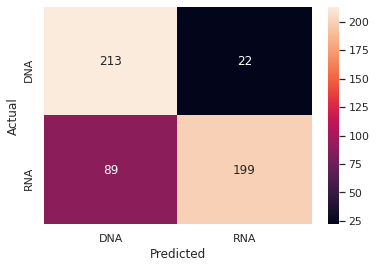

In [12]:
dist_preds, dist_valids = classification(
    df[features],
    np.array(df['macromoleculeType']),
    distance_params,
    n_splits=2
)

for pred, valid in zip(dist_preds, dist_valids):
    mtx = pd.crosstab(
        pd.Series(valid),
        pd.Series(pred),
        rownames=['Actual'],
        colnames=['Predicted'])
    sns.heatmap(mtx, annot=True, fmt='d')
    plt.show()

## Classification with k-fold

In [13]:
model_list = {
    "standard": standard_params,
    "harmonic": harmonic_params,
    "distance": distance_params
}

neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
p_list = [1, 2, 3]

configs_list = list(itertools.product(neighbors_list, p_list))

# Begin the experiment itarating through the knn models list
for model in model_list:
    
    # For each model iterate over every possible configuration of
    # p and number of neighbors
    for config in configs_list:
        
        #Identify the metric
        if config[1] == 1:
            metric = 'manhattan'
        elif config[1] == 2:
            metric = 'euclidean'
        else:
            metric = 'minkowski'
        
        # Define folder to save results
        results_folder = (
            'results/' +
            model + "/" +
            "d_" + str(config[0]) + "/"
        )
        
        # Setup experimens parameters
        model_list[model]['n_neighbors'] = config[0]
        model_list[model]['p'] = config[1]

        # Run model with protein dataframe feaures and
        # using current iteration configurations
        preds, valids = classification(
            df[features],
            np.array(df['macromoleculeType']),
            model_list[model],
            n_splits=5
        )
        
        # Prepare resuls for evaluation
        results = zip(preds, valids)
        
        # Build confusion matrix for each fold and saves as a heatmap
        for i, result in enumerate(results):
            
            file_name = metric + '_split_' + str(i) + '.png'

            mtx = pd.crosstab(
                pd.Series(result[0]),
                pd.Series(result[1]),
                rownames=['Actual'],
                colnames=['Predicted'])
            
            map = sns.heatmap(mtx, annot=True, fmt='d')
            
            plt.savefig(results_folder+file_name)
            plt.close()

## K-fold benchamrking

In [20]:
model_list = {
    "standard": standard_params,
    "harmonic": harmonic_params,
    "distance": distance_params
}

metrics = {
   '1': 'manhattan', 
   '2': 'euclidean', 
   '3': 'minkowski', 
}

neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
p_list = [1, 2, 3]

configs_list = list(itertools.product(neighbors_list, p_list))

results = {
    md+'_'+metrics[mt]: []
    for md in model_list
    for mt in metrics
}

results['k'] = neighbors_list

# Begin the test itarating over the knn models list
for model in model_list:
        
    # For each model iterate over every possible configuration of
    # p and number of neighbors
    for config in configs_list:    
                
        # Identify the metric
        curr_metric = metrics[str(config[1])]
        
        # Setup experimens parameters
        model_list[model]['n_neighbors'] = config[0]
        model_list[model]['p'] = config[1]

        # Run model with protein dataframe feaures and
        # using current iteration configurations
        model_acc = classification_benchmark(
            df[features],
            np.array(df['macromoleculeType']),
            model_list[model],
            n_splits=5
        )
        
        # Add folds mean accuracy
        idx = model + "_" + curr_metric
        results[idx].append(np.average(model_acc))

stats = pd.DataFrame.from_dict(results, orient='columns')
# stats.set_index('k')
stats.to_csv('stats.csv', index=False)

In [42]:
benchmarking = pd.read_csv('stats.csv')
benchmarking.set_index('k', inplace=True)
benchmarking

,standard_manhattan,standard_euclidean,standard_minkowski,harmonic_manhattan,harmonic_euclidean,harmonic_minkowski,distance_manhattan,distance_euclidean,distance_minkowski
k,,,,,,,,,
1,80.877649,79.060834,78.871269,55.233083,55.233083,55.233083,80.877649,79.060834,78.871269
3,83.077239,80.495785,80.591934,55.233083,55.233083,55.233083,82.407382,80.112554,80.113010
5,83.748006,81.931647,81.166097,55.233083,55.233083,55.233083,83.364776,81.260879,80.686717
7,83.366598,81.167464,80.210526,55.328776,55.233083,55.233083,83.557530,81.932103,80.879016
9,83.174755,81.548872,81.357485,55.328776,55.233083,55.233083,83.938938,82.696286,82.122123
11,83.078606,82.601504,81.072226,55.328776,55.233083,55.233083,84.033721,82.600137,81.453634
13,83.365231,82.505810,80.210071,55.328776,55.233083,55.233083,84.224653,82.982456,81.548416
15,83.174299,82.027797,80.496696,55.328776,55.233083,55.233083,83.938483,82.313967,80.879471


In [43]:
# benchmarking.T
benchmarking.columns

Index(['standard_manhattan', 'standard_euclidean', 'standard_minkowski',
       'harmonic_manhattan', 'harmonic_euclidean', 'harmonic_minkowski',
       'distance_manhattan', 'distance_euclidean', 'distance_minkowski'],
      dtype='object')

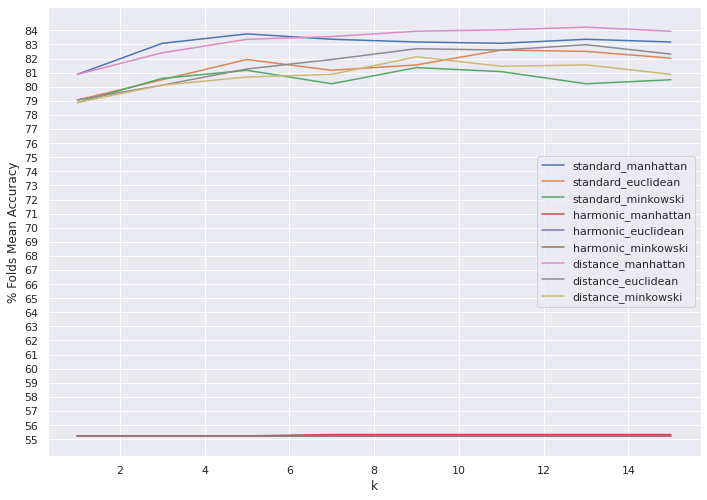

In [60]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))

for column in benchmarking.columns:
    
    ax = sns.lineplot(
        y=column,
        x=benchmarking.index,
        data=benchmarking,
        label=column
    )

plt.yticks(
    list(range(
            int(benchmarking.describe().T['min'].min()),
            int(benchmarking.describe().T['max'].max()) + 1,
        )
    )
)

ax.set(xlabel='k', ylabel='% Folds Mean Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

In [43]:
benchmarking.describe().T

,count,mean,std,min,25%,50%,75%,max
standard_manhattan,8.0,82.982798,0.878503,80.877649,83.078264,83.174527,83.365573,83.748006
standard_euclidean,8.0,81.417464,1.177546,79.060834,80.999544,81.740260,82.147300,82.601504
standard_minkowski,8.0,80.497038,0.786985,78.871269,80.210412,80.544315,81.095694,81.357485
harmonic_manhattan,8.0,55.292891,0.049526,55.233083,55.233083,55.328776,55.328776,55.328776
harmonic_euclidean,8.0,55.233083,0.000000,55.233083,55.233083,55.233083,55.233083,55.233083
harmonic_minkowski,8.0,55.233083,0.000000,55.233083,55.233083,55.233083,55.233083,55.233083
distance_manhattan,8.0,83.292891,1.130354,80.877649,83.125427,83.748006,83.962634,84.224653
distance_euclidean,8.0,81.619902,1.388989,79.060834,80.973798,82.123035,82.624174,82.982456
distance_minkowski,8.0,80.819207,0.996406,78.871269,80.543290,80.879244,81.477330,82.122123
k,8.0,8.000000,4.898979,1.000000,4.500000,8.000000,11.500000,15.000000
